In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import cv2
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

devices = tf.config.experimental.list_physical_devices("GPU")
for device in devices:
    tf.config.experimental.set_memory_growth(device=device, enable=True)

In [2]:
image_dir = "Images/"
images = [os.path.join(image_dir, image) for image in sorted(os.listdir(image_dir))]

image_dir = "Airplanes_Annotations/"
annot = [os.path.join(image_dir, image) for image in sorted(os.listdir(image_dir))]

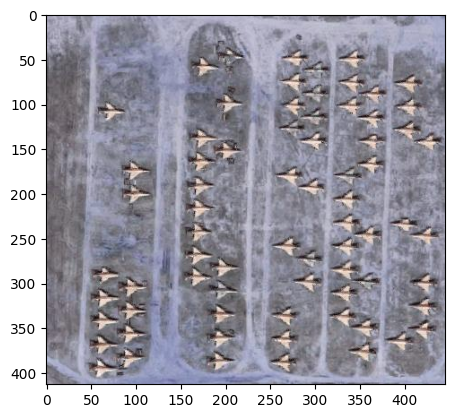

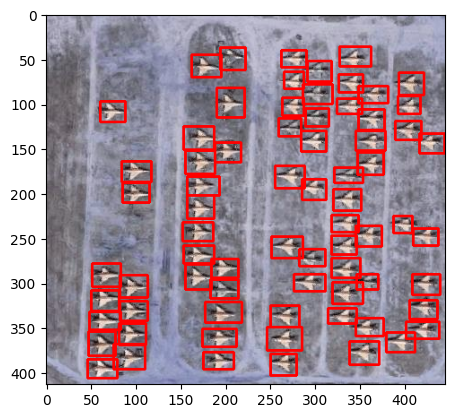

In [3]:
i=19
img = cv2.imread(images[i])
df = pd.read_csv(annot[i])
plt.imshow(img)
for row in df.iterrows():
    x1 = int(row[1][0].split(" ")[0])
    y1 = int(row[1][0].split(" ")[1])
    x2 = int(row[1][0].split(" ")[2])
    y2 = int(row[1][0].split(" ")[3])
    cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
plt.figure()
plt.imshow(img)
plt.show()

## IOU - Intersection over union 

Intersection over Union is simply an evaluation metric. Any algorithm that provides predicted bounding boxes as output can be evaluated using IoU.

More formally, in order to apply Intersection over Union to evaluate an (arbitrary) object detector we need:

1.The ground-truth bounding boxes (i.e., the hand labeled bounding boxes from the testing set that specify where in the image our object is). 

2.The predicted bounding boxes from our model.

After getting these two we can find there intersection and union area,whih ultimately gives us our IoU.

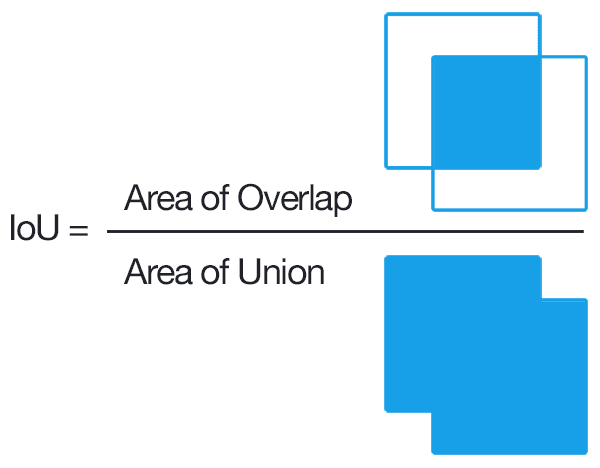

In [4]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

## Creating Several Bounding Boxes using Selective Search

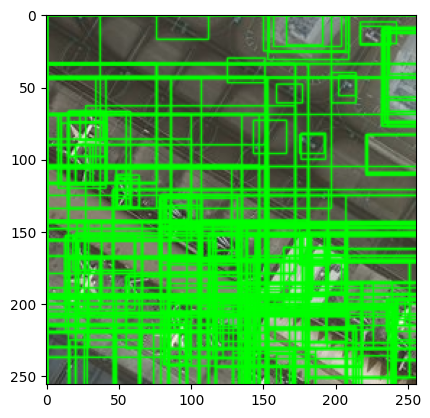

In [136]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

im = cv2.imread(images[0])
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [6]:
train_images=[]
train_labels=[]

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

for i in range(100):
    image = cv2.imread(images[i])
    df = pd.read_csv(annot[i])
    
    if len(df)>0:
        try:

            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})


            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0


            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 5:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <5:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        flag = 1
        except Exception as e:
            print(e)
            print("error in "+filename)
            continue

## Let's break down the code

```python
train_images=[]
train_labels=[]
```
These two lines initialize empty lists `train_images` and `train_labels` which will be used to store the training images and their corresponding labels.

```python
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
```
This line creates an instance of the Selective Search segmentation algorithm from the OpenCV library. Selective Search is a region proposal algorithm used in object detection.

```python
for i in range(len(images)):
    print(i)
    image = cv2.imread(images[i])
    df = pd.read_csv(annot[i])
```
This loop iterates over all the images. For each image, it reads the image file using `cv2.imread` and loads the corresponding annotations from a CSV file using `pd.read_csv`.

```python
if len(df)>0:
    try:
        gtvalues=[]
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
```
If there are annotations for the current image, it iterates over each row of the DataFrame `df`. For each row, it splits the string into coordinates, converts them to integers, and appends them as a dictionary to the list `gtvalues`.

```python
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = image.copy()
counter = 0
falsecounter = 0
flag = 0
fflag = 0
bflag = 0
```
This block sets the base image for the Selective Search algorithm, switches to the fast mode of the algorithm, and processes the image to get the proposed regions. It also initializes several counters and flags used in the next part of the code.

```python
for e,result in enumerate(ssresults):
    if e < 2000 and flag == 0:
        for gtval in gtvalues:
            x,y,w,h = result
            iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
            if counter < 5:
                if iou > 0.70:
                    timage = imout[y:y+h,x:x+w]
                    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                    train_images.append(resized)
                    train_labels.append(1)
                    counter += 1
            else :
                fflag =1
            if falsecounter <5:
                if iou < 0.3:
                    timage = imout[y:y+h,x:x+w]
                    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                    train_images.append(resized)
                    train_labels.append(0)
                    falsecounter += 1
            else :
                bflag = 1
        if fflag == 1 and bflag == 1:
            print("inside")
            flag = 1
```
This block iterates over the results of the Selective Search algorithm. For each proposed region, it calculates the Intersection over Union (IoU) with the ground truth boxes. If the IoU is greater than 0.70, it considers the region as a positive example (object), resizes it to 224x224, and appends it to `train_images` with a label of 1. If the IoU is less than 0.3, it considers the region as a negative example (background), resizes it, and appends it to `train_images` with a label of 0. It does this until it has 5 positive and 5 negative examples or it has iterated over 2000 proposed regions.

The line `timage = imout[y:y+h,x:x+w]` is using array slicing to extract a region of interest from the image.

Here's what each part means:

- `x` and `y` are the coordinates of the top-left corner of the region of interest.
- `w` and `h` are the width and height of the region of interest, respectively.
- `imout[y:y+h,x:x+w]` extracts the region of interest from `imout`. This region starts at `(x, y)` and has a size of `w` pixels wide and `h` pixels high.

So, `timage` is a smaller image that only contains the region of interest from the original image. This is typically used in object detection tasks where you want to focus on a specific part of the image. In this case, `timage` would be used as input to a machine learning model that classifies whether the region contains an object of interest or not.

The variables `fflag`, `bflag`, and `flag` are used to control the flow of the program.

- `fflag` is set to 1 when the program has found 5 positive examples (regions of the image that overlap significantly with the ground truth bounding boxes). 

- `bflag` is set to 1 when the program has found 5 negative examples (regions of the image that do not overlap with the ground truth bounding boxes).

- The condition `if fflag == 1 and bflag == 1:` checks if the program has found 5 positive and 5 negative examples. If it has, it prints "inside" and sets `flag` to 1. 

- Once `flag` is set to 1, the program stops looking for more examples and moves on to the next image. This is because the condition `if e < 2000 and flag == 0:` in the outer loop will no longer be true, so the loop will skip the rest of the code and start the next iteration. This effectively limits the number of examples taken from each image to a maximum of 10 (5 positive and 5 negative).

```python
except Exception as e:
    print(e)
    print("error in "+filename)
    continue
```
This block catches any exceptions that occur during the processing of an image and prints the error message and the filename of the image that caused the error. It then continues with the next image.

## Training

Here each bounding box is used(as cropped from original images) and the labels represent whether the corrosponing images obtained from cropped bounding boxes have plane or not [1 & 0].

In [7]:
X_new = np.array(train_images)
y_new = np.array(train_labels)       

label :  1.     Aeroplane


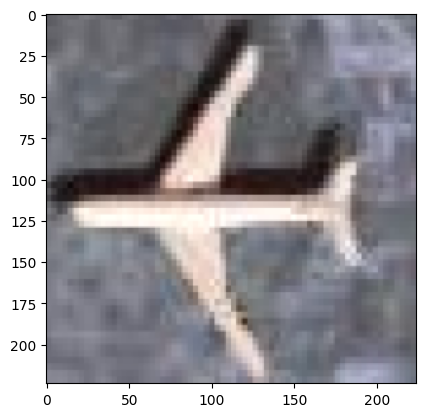

label :  0.     No Aeroplane


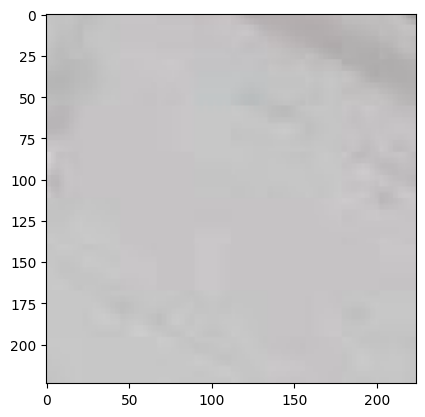

In [133]:
for i in range(164,166):
    plt.imshow(X_new[i])
    if y_new[i]==1:
        print('label :  1.     Aeroplane')
    else:
        print('label :  0.     No Aeroplane')
    plt.show()

## Pre-training
We perform tansfer-learning as pre-training here as we are using VGG16 net which is already trained on Imagenet. 

We are going to train a binary classifier by making all layers as untrainble except two last. 

And then we are going to make a new model which will be stacked on last 2nd output layer.

In [9]:
vggmodel = VGG16(weights='imagenet', include_top=True)

for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
    
X= vggmodel.layers[-2].output

predictions = Dense(1, activation="sigmoid")(X)

model_final = Model(inputs = vggmodel.input, outputs = predictions)

opt = Adam(lr=0.0001)
model_final.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=["accuracy"])

model_final.summary()

2024-04-09 13:12:38.433027: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-09 13:12:38.433044: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-04-09 13:12:38.433047: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-04-09 13:12:38.433071: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-09 13:12:38.433082: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
X_train, X_test , y_train, y_test = train_test_split(X_new,y_new,test_size=0.10)
model_final.fit(X_train,y_train, steps_per_epoch= 10, epochs= 25, validation_data= (X_test,y_test), validation_steps=2)

Epoch 1/25


2024-04-09 13:12:40.361880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 92466.2891 - accuracy: 0.4784 

2024-04-09 13:12:50.437572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 11s 1s/step - loss: 92466.2891 - accuracy: 0.4784 - val_loss: 2821.4551 - val_accuracy: 0.6022
Epoch 2/25
10/10 [==============================] - 11s 1s/step - loss: 16958.8555 - accuracy: 0.4856 - val_loss: 1172.8328 - val_accuracy: 0.2581
Epoch 3/25
10/10 [==============================] - 11s 1s/step - loss: 5195.3833 - accuracy: 0.4976 - val_loss: 15868.2930 - val_accuracy: 0.6022
Epoch 4/25
10/10 [==============================] - 11s 1s/step - loss: 107968.2812 - accuracy: 0.5216 - val_loss: 42914.1914 - val_accuracy: 0.3978
Epoch 5/25
10/10 [==============================] - 11s 1s/step - loss: 57870.0547 - accuracy: 0.5072 - val_loss: 66569.3203 - val_accuracy: 0.3978
Epoch 6/25
10/10 [==============================] - 11s 1s/step - loss: 24787.0840 - accuracy: 0.4255 - val_loss: 57708.2812 - val_accuracy: 0.3978
Epoch 7/25
10/10 [==============================] - 11s 1s/step - loss: 115009.6172 - accuracy: 0.5397 - val_loss: 190709.781

## Testing

1/1 [==============================] - 0s 14ms/step


array([[1.]], dtype=float32)

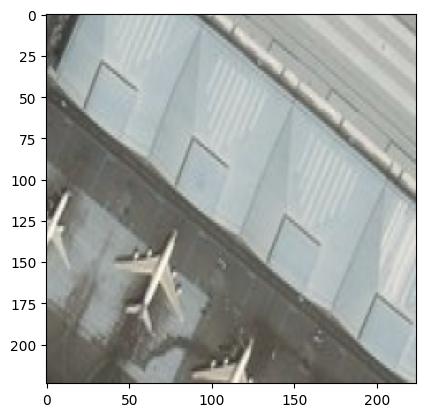

In [124]:
# See if our Model is able to correctly classify the image as 1 indicating Aeroplane presence.

plt.imshow(X_test[10])
model_final.predict(X_test[:1])

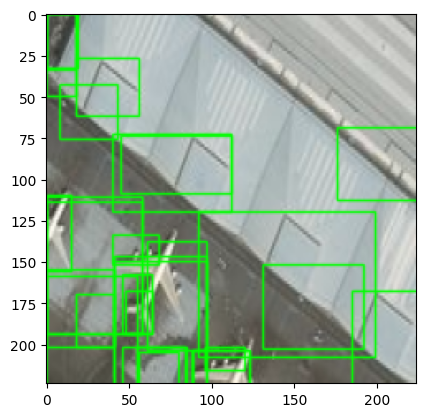

In [134]:
# Select the 10th image from the test set
img = X_test[10]

# Set the base image for selective search
ss.setBaseImage(img)

# Switch to fast mode of selective search
ss.switchToSelectiveSearchFast()

# Process the image and get the results
ssresults = ss.process()

# Create a copy of the image to draw bounding boxes
imout  = img.copy()

# Loop over the seelctive search results
for e,result in enumerate(ssresults):
    # Limit the number of regions to 50
    if e < 50:
        # Get the coordinates of the bounding box
        x,y,w,h = result

        # Create another copy of the image
        imout2 = img.copy()

        # Extract the region from the image
        timage = imout2[y:y+h,x:x+w]

        # Resize the region to 224x224 (required input size for the model)
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)

        # Expand the dimensions of the image as the model expects a batch of images
        im = np.expand_dims(resized, axis=0)

        # Predict the whether region has plane or not using the model
        out= model_final.predict(im,verbose=0)

        # If the model predicts the class as 1, draw a bounding box around the region on the output image
        if out[0][0] ==1:
            cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
            
# Display the output image with bounding boxes
plt.imshow(imout)
plt.show()


As you can see there are multiple bounding box regions. We need only few specific ones for better understanding and more accurate results.

The following steps will help us do that.

## Fine tuning Classification using Logistic Regression

1. First we get our trained VGG16 model it its second last layer.

2. Next we use the model to make predictions and obtain features from the second last layer.

3. We pass the features to logistic regression where do training so the same (image,label) pairs.

In [99]:
layer_name = model_final.layers[-2].name  # Get the name of the second last layer
intermediate_layer_model = Model(inputs=model_final.input, outputs=model_final.get_layer(layer_name).output)

# Now you can use this model to transform your input data to the second last layer's output
intermediate_output = intermediate_layer_model.predict(X_train)

print(intermediate_output.shape)

# Then you can train a logistic regression model on this output
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(intermediate_output, y_train)

 1/26 [>.............................] - ETA: 2s

2024-04-09 16:50:44.926576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 7s 280ms/step
(832, 4096)


LogisticRegression()

Next,

We run the same code for bounding boxes but here instead we get 200 of them. 

And We can also set probability threshold obtained from logistic regression to filter out the bounding boxes.

We also append the bounding box coordinates for further analysis.

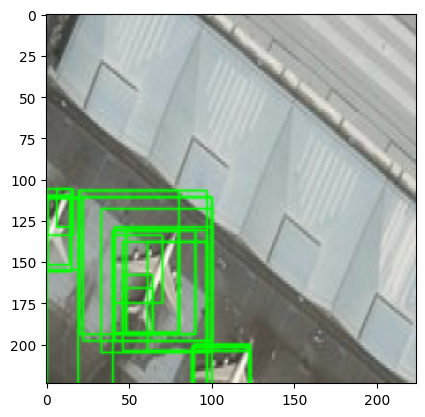

In [119]:
img = X_test[10]
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

imout  = img.copy()
bboxes = []                  # Create list of bounding boxes to get the bounding box coordinates of those having >0.5 probability of having aeroplane.

for e,result in enumerate(ssresults):
    if e < 200:
        x,y,w,h = result
        imout2 = img.copy()
        timage = imout2[y:y+h,x:x+w]
        
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        im = np.expand_dims(resized, axis=0)
        img_features = intermediate_layer_model.predict(im,verbose=0)    # Get features from the second last layer of fine tuned VGG16 model
        out = log_reg.predict_proba(img_features)                                            # Pass the features through our trained logistic regression model
        if out[0][1]>0.5:                                                      # set whatever threshold desire for each bounding box region
            bboxes.append([x,y,w,h])
            cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
            
plt.imshow(imout)
plt.show()

In [ ]:
bboxes = np.array(bboxes)

#  (x, y), (x+w, y+h)
bboxes[:,2] = bboxes[:,0] + bboxes[:,2]     
bboxes[:,3] = bboxes[:,1] + bboxes[:,3]

## NMS - Non Max Supression

It's used in object detection to select the best bounding box that represents an object when multiple bounding boxes overlap.

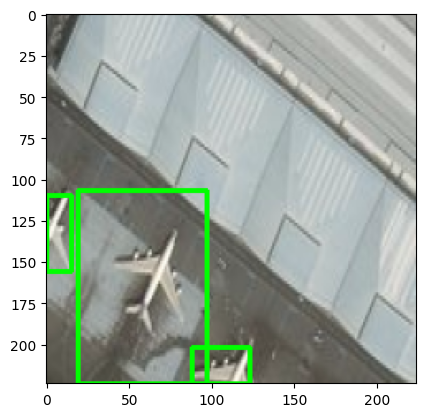

In [140]:
def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return []

    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")

# Apply non-maximum suppression repeatedly
nms_bboxes = non_max_suppression(bboxes, 0.5)
# nms_bboxes = non_max_suppression(nms_bboxes, 0.2)
# nms_bboxes = non_max_suppression(nms_bboxes, 0.1)
# nms_bboxes = non_max_suppression(nms_bboxes, 0.05)

imout2  = img.copy()

# Draw the final bounding boxes
for (x, y, w, h) in nms_bboxes:
    cv2.rectangle(imout2, (x, y), (w, h), (0, 255, 0), 2)
    
plt.imshow(imout2)

## Let's break down the code:

```python
def non_max_suppression(boxes, overlapThresh):
```
This function is called Non-Maximum Suppression (NMS). It's used in object detection to select the best bounding box that represents an object when multiple bounding boxes overlap.

```python
    if len(boxes) == 0:
        return []
```
If there are no bounding boxes, the function returns an empty list.

```python
    pick = []
```
`pick` is a list that will contain the indices of the selected bounding boxes after NMS.

```python
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
```
These lines extract the coordinates of the bounding boxes. `x1` and `y1` represent the top-left corner, while `x2` and `y2` represent the bottom-right corner.

```python
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
```
This line calculates the area of each bounding box.

```python
    idxs = np.argsort(y2)
```
This line sorts the indices of the bounding boxes based on the y-coordinate of the bottom-right corner.

```python
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
```
The loop continues until there are no more indices. It always selects the box with the largest y-coordinate for the bottom-right corner and adds its index to the `pick` list.

```python
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
```
These lines find the coordinates of the intersection of the selected box and the other boxes.

```python
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
```
These lines calculate the width and height of the intersection.

```python
        overlap = (w * h) / area[idxs[:last]]
```
This line calculates the ratio of the area of intersection to the area of each box. This is the Intersection over Union (IoU) used to measure the overlap between two bounding boxes.

```python
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))
```
This line removes the indices of all boxes that have an IoU greater than the threshold with the selected box.

```python
    return boxes[pick].astype("int")
```
Finally, the function returns the selected bounding boxes.